In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from nltk.corpus import stopwords
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.pipeline import make_pipeline

In [76]:
# Import the data
true0 = pd.DataFrame(pd.read_csv('./true.csv'))
fake0 = pd.DataFrame(pd.read_csv('./fake.csv'))

In [77]:
true0.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [78]:
fake0.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [79]:
fake_politics = fake0[fake0.subject.isin(['Government News', 'politics'])]
true_politics = true0[true0.subject == 'politicsNews']

In [80]:
# Filter the news of 2016
fake_politics_2016 = fake_politics[fake_politics['date'].str.contains('2016')]
true_politics_2016 = true_politics[true_politics['date'].str.contains('2016')]
fake1 = fake_politics_2016
true1 = true_politics_2016
fake1['label']=0
true1['label']=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [81]:
# Combine both true news and fake news published in 2016
news=fake1.append(true1)
news.head()

,title,text,subject,date,label
12023,TRUMP DITCHES PRESS To Make “Last Minute” Surp...,President-elect Donald Trump played a round of...,politics,"Dec 31, 2016",0
12024,"COUNTDOWN TICKER: Obama Leaves Office In…5,4,3...",(function(){ var s=document.createElement('scr...,politics,"Dec 31, 2016",0
12025,BOOM! TOMI LAHREN’S Top Tips For Liberals In 2...,,politics,"Dec 31, 2016",0
12026,"YES, OBAMA…There Is A Magic Wand! [Video]",,politics,"Dec 31, 2016",0
12027,HA! DONALD TRUMP’S Unusual New Year’s Tweet To...,President-elect Donald Trump is throwing a pri...,politics,"Dec 31, 2016",0


In [82]:
# Import stopword set
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luanyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [83]:
# Define a series of data cleaning functions
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing punctuation
def remove_punctuation(text):
    pattern = '[’!"#$%&\'()*+,-./:;<=>?@[\\]"^_`{|}~]+' 
    text = re.sub(pattern,'',text)
    return text

#Since 'reuters' is shown in almost every piece of true news, we want to remove it from the true news
def remove_reuters(text):
    if 'reuters' in text.split()[0:5]:
        text = text[text.find('reuters'):]
        text = text.split(' ', 1)[1]
    return text
    

#Removing the noisy text
def denoise_text(text):
    text.lower()
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_reuters(text)
      
    return text


In [84]:
#Apply functions on text and title columns
news['text']=news['text'].apply(denoise_text)
news['title']=news['title'].apply(denoise_text)

In [85]:
# drop those empty text data 
news = news[news.text != '']
# Shuffle the news
news = news.sample(frac = 1, random_state = 1)
news.head(10)

,title,text,subject,date,label
9917,mississippi governor signs law allowing armed ...,mississippi governor phil bryant signed gun ri...,politicsNews,"April 15, 2016",1
13107,watch cnn host freak onair “factcheck” proves ...,hangon hangon hangon hangon brooke baldwin des...,politics,"Sep 2, 2016",0
10519,kerry trip cuba rights dialogue canceled us of...,tentative plans us secretary state john kerry ...,politicsNews,"March 4, 2016",1
10945,special report obama gun control advocates sto...,barack obama might seem unlikely investor fire...,politicsNews,"February 5, 2016",1
10495,white house adviser rhodes meet cuban american...,president barack obamas deputy national securi...,politicsNews,"March 4, 2016",1
8137,us lawmakers say afghanistan corruption threat...,us senators questioned state department offici...,politicsNews,"September 15, 2016",1
14256,unhinged radical leftists try storm trumps uta...,utah protest planned organized far left effort...,politics,"Mar 19, 2016",0
13814,five state department rules hillary violated,hillary doubles false claim rules clarified le...,politics,"May 27, 2016",0
14165,witch hunt communist california raids home man...,make mistake it seeing tactics used communist ...,politics,"Apr 6, 2016",0
14448,gag hollywood latinos gush hillary nevada race...,pandering hillary best first black vote meetin...,politics,"Feb 20, 2016",0


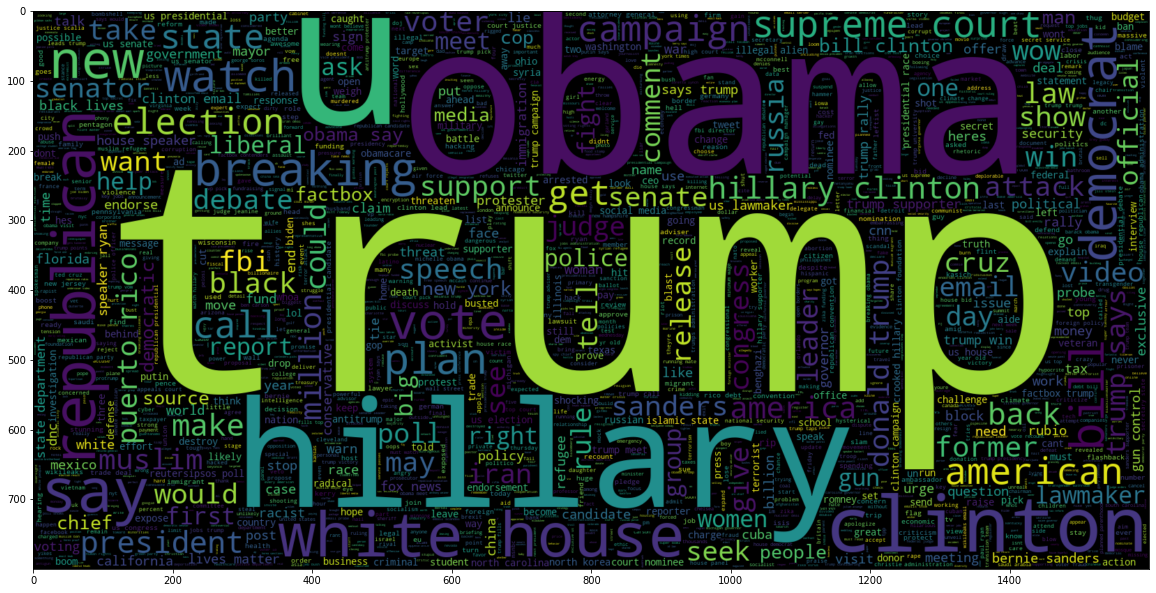

In [12]:
# Wordcloud of the titles of all news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(news.title))
plt.imshow(wc , interpolation = 'bilinear')

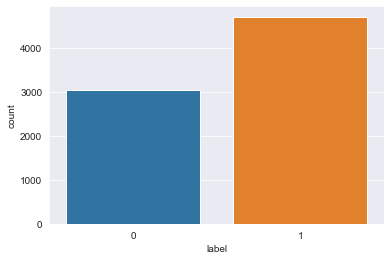

In [13]:

sns.set_style("darkgrid")
sns.countplot(news.label)

(array([3.000e+01, 2.221e+03, 3.878e+03, 1.014e+03, 3.280e+02, 2.020e+02,
        5.700e+01, 1.900e+01, 6.000e+00, 2.000e+00]),
 array([ 2. ,  4.8,  7.6, 10.4, 13.2, 16. , 18.8, 21.6, 24.4, 27.2, 30. ]),
 <a list of 10 Patch objects>)

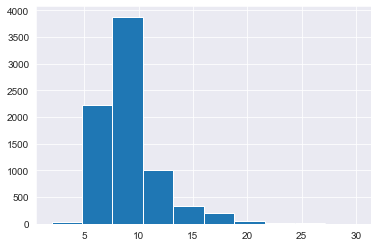

In [18]:
len_title = [len(i.split()) for i in news['title']]
plt.hist(len_title)

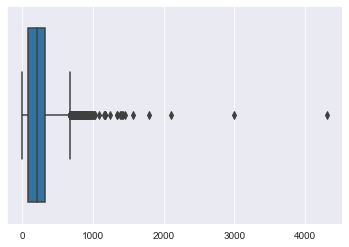

In [19]:
len_text = [len(i.split()) for i in news['text']]
sns.boxplot(len_text)

In [86]:
# Choose the title and text columns and split the data
X = news[['title', 'text']]
Y = news[['label']]
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)

In [87]:
# Split the data as two sources: title and text 
x_train_title = x_train['title']
x_train_text = x_train['text']
x_test_title = x_test['title']
x_test_text = x_test['text']

y_train = y_train['label']
y_test = y_test['label']

# Part 1. Prediction based on Title

# Model1: Naive Bayes Model with TF-IDF inputs

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

In [18]:
model1_title = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_title.fit(x_train_title, y_train)
pred1_title = model1_title.predict(x_test_title)
f1_model1_title = f1_score(y_test, pred1_title, average = 'macro')

print('F1 score of model1_title:', f1_model1_title)

F1 score of model1_title: 0.9281289373295099


Text(24.0, 0.5, 'predicted label')

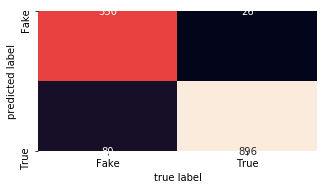

In [19]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_title)
label_name = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


# Model 2: Single Layer Neural Network Model with TF-IDF inputs

In [24]:
from sklearn.neural_network import MLPClassifier

model2_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ),random_state=1, verbose = True))
model2_title.fit(x_train_title, y_train)

Iteration 1, loss = 0.67931797
Iteration 2, loss = 0.58607968
Iteration 3, loss = 0.45919279
Iteration 4, loss = 0.33990822
Iteration 5, loss = 0.25078905
Iteration 6, loss = 0.18947957
Iteration 7, loss = 0.14758040
Iteration 8, loss = 0.11841614
Iteration 9, loss = 0.09669657
Iteration 10, loss = 0.08061329
Iteration 11, loss = 0.06804653
Iteration 12, loss = 0.05814917
Iteration 13, loss = 0.05024183
Iteration 14, loss = 0.04372418
Iteration 15, loss = 0.03837055
Iteration 16, loss = 0.03390911
Iteration 17, loss = 0.03015030
Iteration 18, loss = 0.02696851
Iteration 19, loss = 0.02423972
Iteration 20, loss = 0.02190843
Iteration 21, loss = 0.01992083
Iteration 22, loss = 0.01814972
Iteration 23, loss = 0.01662708
Iteration 24, loss = 0.01528897
Iteration 25, loss = 0.01409501
Iteration 26, loss = 0.01302000
Iteration 27, loss = 0.01207480
Iteration 28, loss = 0.01121923
Iteration 29, loss = 0.01049916
Iteration 30, loss = 0.00979514
Iteration 31, loss = 0.00917126
Iteration 32, los

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(50,), random_state=1,
                               verbose=True))])

In [25]:
pred2_title = model2_title.predict(x_test_title)
f1_model2_title = f1_score(y_test, pred2_title, average = 'macro')
print('F1 score of model2_title:', f1_model2_title)

F1 score of model2_title: 0.9431500606551619


# Model 3: Multi Layer Neural Network Model with TF-IDF inputs

In [26]:
model3_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(200,200,200,200, ),random_state=1, verbose = True))
model3_title.fit(x_train_title, y_train)

Iteration 1, loss = 0.58296919
Iteration 2, loss = 0.10330109
Iteration 3, loss = 0.01375077
Iteration 4, loss = 0.00168248
Iteration 5, loss = 0.00049345
Iteration 6, loss = 0.00030998
Iteration 7, loss = 0.00025794
Iteration 8, loss = 0.00023576
Iteration 9, loss = 0.00022034
Iteration 10, loss = 0.00020969
Iteration 11, loss = 0.00020404
Iteration 12, loss = 0.00020012
Iteration 13, loss = 0.00019695
Iteration 14, loss = 0.00019417
Iteration 15, loss = 0.00019171
Iteration 16, loss = 0.00018949
Iteration 17, loss = 0.00018740
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200),
                               random_state=1, verbose=True))])

In [27]:
pred3_title = model3_title.predict(x_test_title)
f1_model3_title = f1_score(y_test, pred3_title, average = 'macro')
print('F1 score of model3_title:', f1_model3_title)

F1 score of model3_title: 0.9406242007277541


# Model 4: Single Layer Neural Network Model with embedding inputs

In [24]:
# Convert the raw embedding file to a dictionary.
f = open('glove.6B.100d.txt', 'r', encoding='UTF-8')
gloveModel = {}
for line in f:
    splitLines = line.split()
    word = splitLines[0]
    wordEmbedding = np.asarray(splitLines[1:])
    gloveModel[word] = wordEmbedding

In [25]:
# Convert the vector format of embedding dictionary, from string to float
WordVector ={key:np.array([float(number) for number in item], dtype=np.float32) for key, item in gloveModel.items()}

In [26]:
# get the embedding of each file
def calc_doc_embedding(doc, embeddings, embed_size, OOV_embed):
    doc_list = doc.lower().split()
    doc_embed = np.zeros(embed_size)
    length = 0
    for word in doc_list:
        if word in embeddings:
            doc_embed = doc_embed + embeddings[word]
            length += 1
        else:
            if word in OOV_embed:
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
            else:
                OOV_embed[word] = np.random.rand(embed_size)
                doc_embed = doc_embed + OOV_embed[word]
                length += 1
    doc_embed = doc_embed / length
    return doc_embed

x_train_title_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_train_title])
x_test_title_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_test_title])

In [27]:
# Fit the model
model4_title = MLPClassifier(hidden_layer_sizes=(50), random_state = 1, max_iter=500,verbose=True)
model4_title.fit(x_train_title_embed, y_train)

Iteration 1, loss = 0.57068316
Iteration 2, loss = 0.40627072
Iteration 3, loss = 0.34759544
Iteration 4, loss = 0.32367052
Iteration 5, loss = 0.30905558
Iteration 6, loss = 0.29840986
Iteration 7, loss = 0.29158192
Iteration 8, loss = 0.28490894
Iteration 9, loss = 0.27813581
Iteration 10, loss = 0.27576389
Iteration 11, loss = 0.27035669
Iteration 12, loss = 0.26859526
Iteration 13, loss = 0.26497867
Iteration 14, loss = 0.26307971
Iteration 15, loss = 0.26377482
Iteration 16, loss = 0.25980700
Iteration 17, loss = 0.25768803
Iteration 18, loss = 0.26116673
Iteration 19, loss = 0.26023738
Iteration 20, loss = 0.25657353
Iteration 21, loss = 0.25200889
Iteration 22, loss = 0.25085913
Iteration 23, loss = 0.24962014
Iteration 24, loss = 0.24860646
Iteration 25, loss = 0.24580547
Iteration 26, loss = 0.24468390
Iteration 27, loss = 0.24371766
Iteration 28, loss = 0.24372966
Iteration 29, loss = 0.24112611
Iteration 30, loss = 0.24096658
Iteration 31, loss = 0.23847413
Iteration 32, los

Iteration 261, loss = 0.06072268
Iteration 262, loss = 0.05982082
Iteration 263, loss = 0.05887949
Iteration 264, loss = 0.05846868
Iteration 265, loss = 0.05992653
Iteration 266, loss = 0.05845372
Iteration 267, loss = 0.05743377
Iteration 268, loss = 0.05717350
Iteration 269, loss = 0.05619014
Iteration 270, loss = 0.06043238
Iteration 271, loss = 0.05638610
Iteration 272, loss = 0.06411634
Iteration 273, loss = 0.09576677
Iteration 274, loss = 0.06100325
Iteration 275, loss = 0.05617836
Iteration 276, loss = 0.05498938
Iteration 277, loss = 0.05399090
Iteration 278, loss = 0.05306595
Iteration 279, loss = 0.05259536
Iteration 280, loss = 0.05333959
Iteration 281, loss = 0.05183956
Iteration 282, loss = 0.05181932
Iteration 283, loss = 0.05681481
Iteration 284, loss = 0.05091812
Iteration 285, loss = 0.05038511
Iteration 286, loss = 0.05064373
Iteration 287, loss = 0.05393038
Iteration 288, loss = 0.05003429
Iteration 289, loss = 0.04912530
Iteration 290, loss = 0.04870378
Iteration 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=50, max_iter=500, random_state=1, verbose=True)

In [28]:
pred4_title = model4_title.predict(x_test_title_embed)
f1_model4_title = f1_score(y_test, pred4_title, average = 'macro')
print('F1 score of model4_title:', f1_model4_title)

F1 score of model4_title: 0.8985029076290801


# Model 5: Multi Layer Neural Network Model with embedding inputs

In [29]:
model5_title = MLPClassifier(hidden_layer_sizes=(200,200,200,200), random_state = 1, max_iter=500,verbose=True)
model5_title.fit(x_train_title_embed, y_train)

Iteration 1, loss = 0.42589068
Iteration 2, loss = 0.27743295
Iteration 3, loss = 0.24280279
Iteration 4, loss = 0.22762542
Iteration 5, loss = 0.19743963
Iteration 6, loss = 0.17427490
Iteration 7, loss = 0.15565068
Iteration 8, loss = 0.16185257
Iteration 9, loss = 0.13380592
Iteration 10, loss = 0.11388567
Iteration 11, loss = 0.09846512
Iteration 12, loss = 0.06599504
Iteration 13, loss = 0.05202433
Iteration 14, loss = 0.03436225
Iteration 15, loss = 0.02414452
Iteration 16, loss = 0.01848573
Iteration 17, loss = 0.02164189
Iteration 18, loss = 0.05076758
Iteration 19, loss = 0.01984236
Iteration 20, loss = 0.00854709
Iteration 21, loss = 0.00664950
Iteration 22, loss = 0.00368103
Iteration 23, loss = 0.00180018
Iteration 24, loss = 0.00086657
Iteration 25, loss = 0.00054389
Iteration 26, loss = 0.00043961
Iteration 27, loss = 0.00039509
Iteration 28, loss = 0.00036629
Iteration 29, loss = 0.00034492
Iteration 30, loss = 0.00032847
Iteration 31, loss = 0.00031534
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200), max_iter=500,
              random_state=1, verbose=True)

In [30]:
pred5_title = model5_title.predict(x_test_title_embed)
f1_model5_title = f1_score(y_test, pred5_title, average = 'macro')
print('F1 score of model5_title:', f1_model5_title)

F1 score of model5_title: 0.8969880480271387


# Model 6 : Simple RNN Model with self-defined Embeddings Input

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Bidirectional

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news['title'])
word_index = tokenizer.word_index

max_vocab = len(word_index) + 1
max_title_length = max([len(i.split()) for i in news['title']])


# tokenize the text into vectors 
x_train_title_rnn = tokenizer.texts_to_sequences(x_train_title)
x_test_title_rnn = tokenizer.texts_to_sequences(x_test_title)

#Apply padding so we have the same length for each article
x_train_title_rnn = pad_sequences(x_train_title_rnn, maxlen=max_title_length)
x_test_title_rnn = pad_sequences(x_test_title_rnn, maxlen=max_title_length)

In [45]:
model6_title = Sequential(name = 'model6_title')
model6_title.add(Embedding(input_dim = max_vocab, output_dim = 100, trainable=True))
model6_title.add(SimpleRNN(32))
model6_title.add(Dense(1, activation = 'sigmoid'))
model6_title.summary()

Model: "model6_title"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1220700   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,224,989
Trainable params: 1,224,989
Non-trainable params: 0
_________________________________________________________________


In [46]:
model6_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model6_title_rnn = model6_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model6_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 2s 10ms/step - loss: 0.3230 - accuracy: 0.8609 - val_loss: 0.1919 - val_accuracy: 0.9243
Epoch 2/10
175/175 [==============================] - 2s 9ms/step - loss: 0.0668 - accuracy: 0.9807 - val_loss: 0.1696 - val_accuracy: 0.9259
Epoch 3/10
175/175 [==============================] - 2s 9ms/step - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.2388 - val_accuracy: 0.9195
Epoch 4/10
175/175 [==============================] - 1s 8ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.2189 - val_accuracy: 0.9259
Epoch 5/10
175/175 [==============================] - 1s 8ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2443 - val_accuracy: 0.9227
Epoch 6/10
175/175 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2759 - val_accuracy: 0.9227
Epoch 7/10
175/175 [==============================] - 1s 8ms/step - loss: 7.6955e-04 - accuracy: 1.0000 - val_loss: 0.3012 - val_accuracy: 0.9195
E

[0.2947280704975128, 0.9271907210350037]

In [47]:
# Define a function which can visualize the accuracy and loss with time
def model_plot(model):

    history_dict = model.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = model.epoch

    plt.figure(figsize=(12,9))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=20)
    plt.xlabel('Epochs', size=20)
    plt.ylabel('Loss', size=20)
    plt.legend(prop={'size': 20})
    plt.show()

    plt.figure(figsize=(12,9))
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=20)
    plt.xlabel('Epochs', size=20)

    plt.ylabel('Accuracy', size=20)
    plt.legend(prop={'size': 20})
    plt.ylim((0.5,1))
    plt.show()

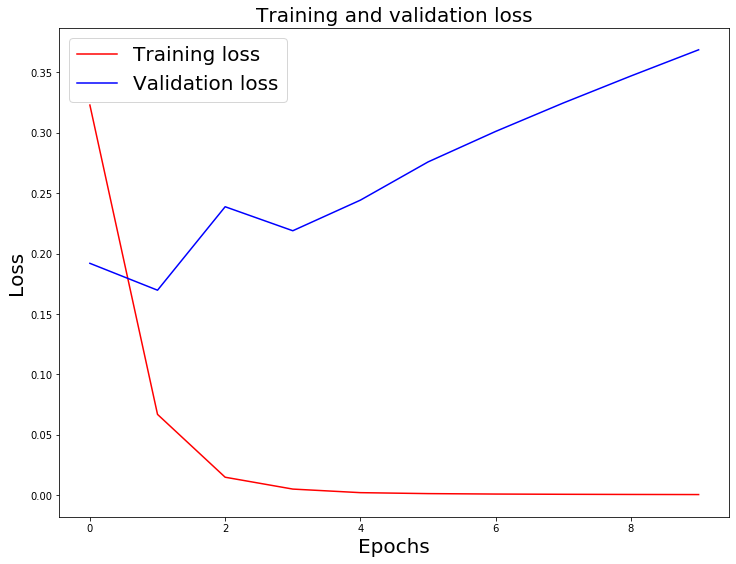

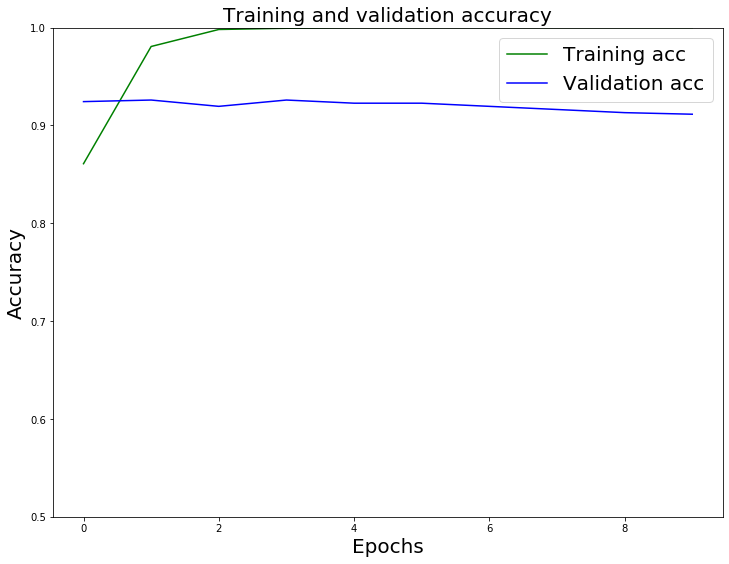

In [48]:
model_plot(model6_title_rnn)

In [49]:
# Define a function which can measure the macro_F1 score of RNN models
def rnn_f1(model, x_test_rnn):
    pred_prob = model.predict(x_test_rnn)
    pred = []
    
    for i in pred_prob:
        if i >= 0.5:
            pred.append(1)
        else:
            pred.append(0)
            
    f1_macro = f1_score(y_test, pred, average = 'macro')
    
    return f1_macro

In [50]:
f1_model6_title = rnn_f1(model6_title, x_test_title_rnn)
print('F1 score of model6_title_rnn: ', f1_model6_title)

F1 score of model6_title_rnn:  0.9237649116721285


# Model 7 : Simple RNN Model with glove Embeddings Input

In [36]:
# Generate the embedding matrix for model building
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [40]:
model7_title = Sequential(name = 'model7_title_glove')
model7_title.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_title_length, weights=[embedding_matrix], trainable= False))
model7_title.add(SimpleRNN(32))
model7_title.add(Dense(1, activation = 'sigmoid'))
model7_title.summary()

Model: "model7_title_glove"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1220700   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,224,989
Trainable params: 4,289
Non-trainable params: 1,220,700
_________________________________________________________________


In [41]:
model7_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7_title_rnn = model7_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model7_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 1s 6ms/step - loss: 0.4787 - accuracy: 0.7708 - val_loss: 0.3067 - val_accuracy: 0.8808
Epoch 2/10
175/175 [==============================] - 1s 5ms/step - loss: 0.2890 - accuracy: 0.8848 - val_loss: 0.2691 - val_accuracy: 0.8792
Epoch 3/10
175/175 [==============================] - 1s 5ms/step - loss: 0.2434 - accuracy: 0.9088 - val_loss: 0.2519 - val_accuracy: 0.8953
Epoch 4/10
175/175 [==============================] - 1s 4ms/step - loss: 0.2235 - accuracy: 0.9176 - val_loss: 0.2433 - val_accuracy: 0.9002
Epoch 5/10
175/175 [==============================] - 1s 4ms/step - loss: 0.2068 - accuracy: 0.9221 - val_loss: 0.2484 - val_accuracy: 0.8921
Epoch 6/10
175/175 [==============================] - 1s 4ms/step - loss: 0.1837 - accuracy: 0.9332 - val_loss: 0.2202 - val_accuracy: 0.9195
Epoch 7/10
175/175 [==============================] - 1s 4ms/step - loss: 0.1770 - accuracy: 0.9343 - val_loss: 0.2339 - val_accuracy: 0.9066
Epoch 

[0.21464134752750397, 0.9175257682800293]

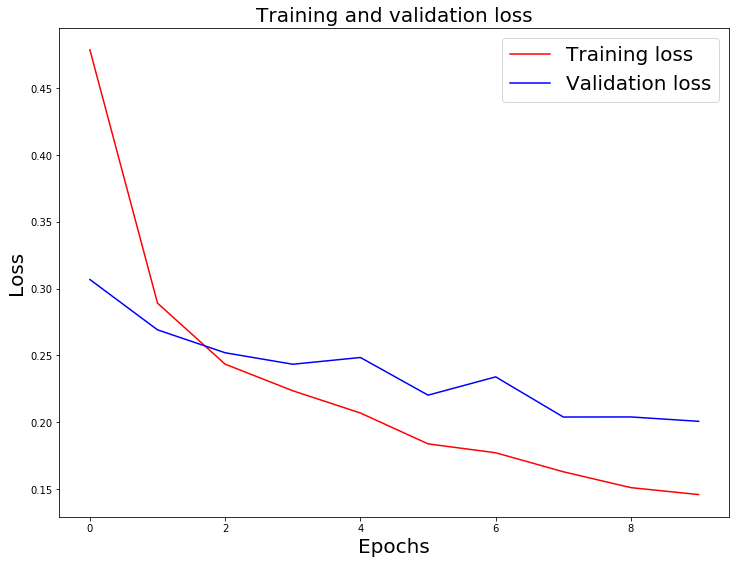

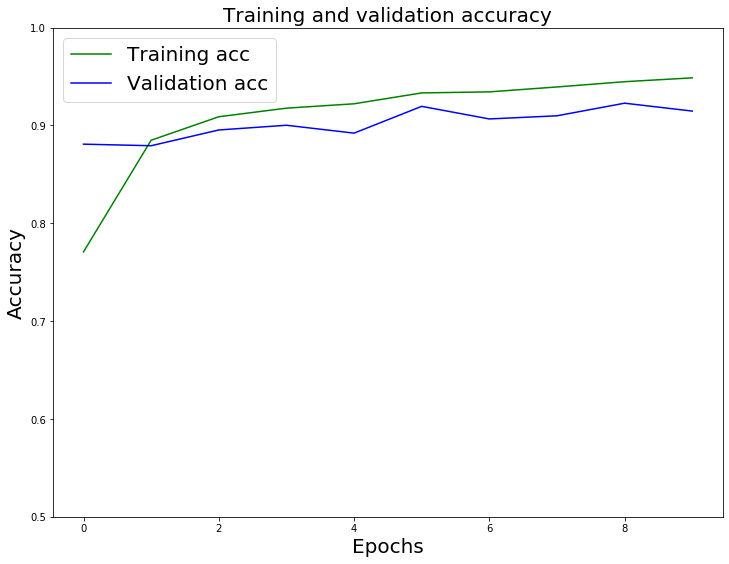

In [42]:
model_plot(model7_title_rnn)

In [43]:
f1_model7_title = rnn_f1(model7_title, x_test_title_rnn)
print('F1 score of model7_title_glove: ', f1_model7_title)

F1 score of model7_title_glove:  0.9139588227548976


# Model 8: Complex RNN Model with Glove Embedding Inputs

In [141]:
model8_title = Sequential(name = 'model8_title')
model8_title.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_title_length, weights=[embedding_matrix], trainable=False))
model8_title.add(Bidirectional(LSTM(64, dropout = 0.2, return_sequences=True)))
model8_title.add(Bidirectional(LSTM(16, return_sequences=False)))
model8_title.add(Dense(32, activation = 'relu'))
model8_title.add(Dropout(rate=0.5))
model8_title.add(Dense(1, activation = 'sigmoid'))
model8_title.summary()

Model: "model8_title"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 100)           7403200   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 7,507,329
Trainable params: 104,129
Non-trainable params: 7,403,200
______________________________________

In [142]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model8_title.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model8_title_final = model8_title.fit(x_train_title_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32,callbacks=[early_stop])
model8_title.evaluate(x_test_title_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 6s 32ms/step - loss: 0.4944 - accuracy: 0.7650 - val_loss: 0.3945 - val_accuracy: 0.8245
Epoch 2/10
175/175 [==============================] - 4s 23ms/step - loss: 0.3787 - accuracy: 0.8351 - val_loss: 0.3237 - val_accuracy: 0.8583
Epoch 3/10
175/175 [==============================] - 4s 22ms/step - loss: 0.3358 - accuracy: 0.8537 - val_loss: 0.2997 - val_accuracy: 0.8631
Epoch 4/10
175/175 [==============================] - 4s 22ms/step - loss: 0.3107 - accuracy: 0.8669 - val_loss: 0.3072 - val_accuracy: 0.8519
Epoch 5/10
175/175 [==============================] - 4s 25ms/step - loss: 0.2765 - accuracy: 0.8861 - val_loss: 0.2620 - val_accuracy: 0.8808
Epoch 6/10
175/175 [==============================] - 4s 23ms/step - loss: 0.2635 - accuracy: 0.8931 - val_loss: 0.3099 - val_accuracy: 0.8712
Epoch 7/10
175/175 [==============================] - 4s 23ms/step - loss: 0.2328 - accuracy: 0.9110 - val_loss: 0.2561 - val_accuracy: 0.8905

[0.23711882531642914, 0.8988401889801025]

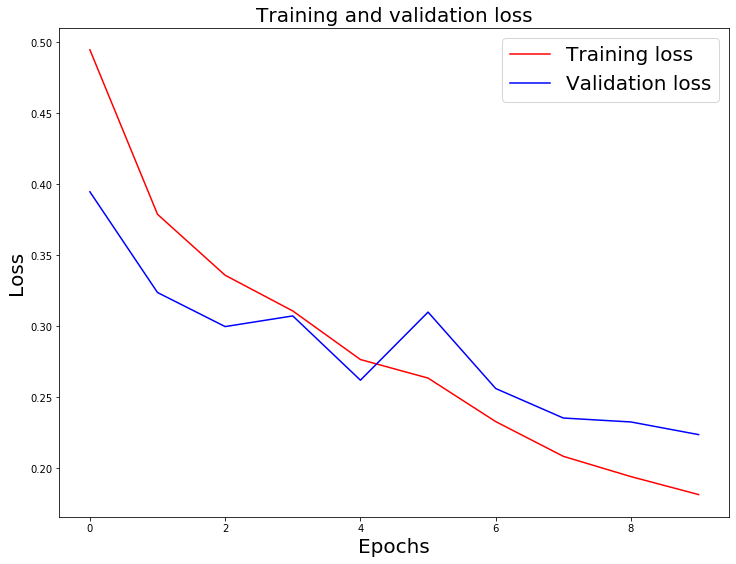

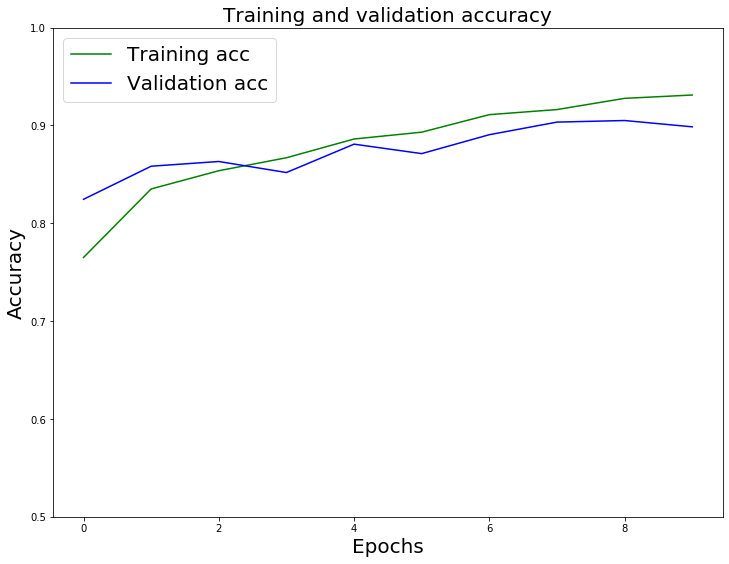

In [143]:
model_plot(model8_title_final)

In [144]:
f1_model8_title = rnn_f1(model8_title, x_test_title_rnn)
print('F1 score of model8_title: ', f1_model8_title)

F1 score of model8_title:  0.8935172257073497


# 2. Prediction based on Text

# Model 1: Naive Bayes Model with TF-IDF inputs

In [68]:
model1_text = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_text.fit(x_train_text, y_train)
pred1_text = model1_text.predict(x_test_text)
f1_model1_text = f1_score(y_test, pred1_text, average = 'macro')

print('F1 score of mode21_text: ', f1_model1_text)


F1 score of mode21_text:  0.6561700963251216


Text(24.0, 0.5, 'predicted label')

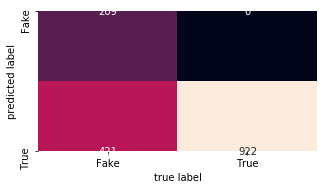

In [69]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_text)
label_name = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


# Model 2: Single Layer Neural Network Model with TF-IDF inputs

In [70]:
model2_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_text.fit(x_train_text, y_train)

Iteration 1, loss = 0.60506918
Iteration 2, loss = 0.40863560
Iteration 3, loss = 0.25178339
Iteration 4, loss = 0.15828300
Iteration 5, loss = 0.10529325
Iteration 6, loss = 0.07376747
Iteration 7, loss = 0.05396829
Iteration 8, loss = 0.04103129
Iteration 9, loss = 0.03210281
Iteration 10, loss = 0.02582662
Iteration 11, loss = 0.02131203
Iteration 12, loss = 0.01790139
Iteration 13, loss = 0.01529733
Iteration 14, loss = 0.01324577
Iteration 15, loss = 0.01164221
Iteration 16, loss = 0.01032906
Iteration 17, loss = 0.00924273
Iteration 18, loss = 0.00835967
Iteration 19, loss = 0.00761715
Iteration 20, loss = 0.00700036
Iteration 21, loss = 0.00647684
Iteration 22, loss = 0.00601770
Iteration 23, loss = 0.00562620
Iteration 24, loss = 0.00528585
Iteration 25, loss = 0.00498615
Iteration 26, loss = 0.00471851
Iteration 27, loss = 0.00447823
Iteration 28, loss = 0.00426447
Iteration 29, loss = 0.00407562
Iteration 30, loss = 0.00390248
Iteration 31, loss = 0.00374778
Iteration 32, los

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(50,), random_state=1,
                               verbose=True))])

In [71]:
pred2_text = model2_text.predict(x_test_text)
f1_model2_text = f1_score(y_test, pred2_text, average = 'macro')

print('F1 score of model2_text: ', f1_model2_text)


F1 score of model2_text:  0.9738057371355868


# Model 3: Multi-Layer Neural Network Model with TF-IDF inputs

In [72]:
model3_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(100,100,100, ), random_state=1, verbose = True))
model3_text.fit(x_train_text, y_train)

Iteration 1, loss = 0.54850161
Iteration 2, loss = 0.12517372
Iteration 3, loss = 0.00760103
Iteration 4, loss = 0.00131876
Iteration 5, loss = 0.00071834
Iteration 6, loss = 0.00053065
Iteration 7, loss = 0.00043286
Iteration 8, loss = 0.00036933
Iteration 9, loss = 0.00032045
Iteration 10, loss = 0.00028963
Iteration 11, loss = 0.00027108
Iteration 12, loss = 0.00025796
Iteration 13, loss = 0.00024654
Iteration 14, loss = 0.00022971
Iteration 15, loss = 0.00021676
Iteration 16, loss = 0.00020943
Iteration 17, loss = 0.00020403
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                               random_state=1, verbose=True))])

In [73]:
pred3_text = model3_text.predict(x_test_text)
f1_model3_text = f1_score(y_test, pred3_text, average = 'macro')

print('F1 score of model3_text: ', f1_model3_text)


F1 score of model3_text:  0.9778829449159404


# Model 4 : Single Neural Network Model with embeddings inputs

In [74]:
x_train_text_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_train_text])
x_test_text_embed = np.vstack([calc_doc_embedding(doc, WordVector, 100, {}) for doc in x_test_text])
#fit model
model4_text = MLPClassifier(hidden_layer_sizes=(50), max_iter=500,random_state=1,verbose=True)
model4_text.fit(x_train_text_embed, y_train)


Iteration 1, loss = 0.60289111
Iteration 2, loss = 0.47484354
Iteration 3, loss = 0.40443217
Iteration 4, loss = 0.37225466
Iteration 5, loss = 0.34670369
Iteration 6, loss = 0.33150523
Iteration 7, loss = 0.31563371
Iteration 8, loss = 0.30399191
Iteration 9, loss = 0.29307174
Iteration 10, loss = 0.28372308
Iteration 11, loss = 0.27717832
Iteration 12, loss = 0.26854285
Iteration 13, loss = 0.26155854
Iteration 14, loss = 0.25679319
Iteration 15, loss = 0.25531617
Iteration 16, loss = 0.25026951
Iteration 17, loss = 0.24243529
Iteration 18, loss = 0.24122231
Iteration 19, loss = 0.23483592
Iteration 20, loss = 0.23174264
Iteration 21, loss = 0.22974611
Iteration 22, loss = 0.22597631
Iteration 23, loss = 0.22517128
Iteration 24, loss = 0.22005026
Iteration 25, loss = 0.21755824
Iteration 26, loss = 0.21548755
Iteration 27, loss = 0.21346719
Iteration 28, loss = 0.21649976
Iteration 29, loss = 0.20866767
Iteration 30, loss = 0.20947958
Iteration 31, loss = 0.20610330
Iteration 32, los

Iteration 258, loss = 0.10085476
Iteration 259, loss = 0.10011053
Iteration 260, loss = 0.09987398
Iteration 261, loss = 0.10506058
Iteration 262, loss = 0.09986567
Iteration 263, loss = 0.09976061
Iteration 264, loss = 0.09871363
Iteration 265, loss = 0.09929825
Iteration 266, loss = 0.10132249
Iteration 267, loss = 0.10310732
Iteration 268, loss = 0.09957469
Iteration 269, loss = 0.10066958
Iteration 270, loss = 0.10230765
Iteration 271, loss = 0.09959104
Iteration 272, loss = 0.10928484
Iteration 273, loss = 0.09979893
Iteration 274, loss = 0.10037345
Iteration 275, loss = 0.11028540
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=50, max_iter=500, random_state=1, verbose=True)

In [75]:
pred4_text = model4_text.predict(x_test_text_embed)
f1_model4_text = f1_score(y_test, pred4_text, average = 'macro')
print('F1 score of model4_text: ', f1_model4_text)

F1 score of model4_text:  0.9299498997349909


# Model 5 : Multi-Layer Neural Network Model with embeddings inputs

In [76]:
#fit model
model5_text = MLPClassifier(hidden_layer_sizes=(200,200,200,200),random_state=1, max_iter=500,verbose=True)
model5_text.fit(x_train_text_embed, y_train)

Iteration 1, loss = 0.46180979
Iteration 2, loss = 0.28900623
Iteration 3, loss = 0.25001450
Iteration 4, loss = 0.21536327
Iteration 5, loss = 0.20846500
Iteration 6, loss = 0.19997841
Iteration 7, loss = 0.18441005
Iteration 8, loss = 0.20324647
Iteration 9, loss = 0.18098262
Iteration 10, loss = 0.20329124
Iteration 11, loss = 0.15823074
Iteration 12, loss = 0.14371287
Iteration 13, loss = 0.17687442
Iteration 14, loss = 0.14795030
Iteration 15, loss = 0.12630061
Iteration 16, loss = 0.11630169
Iteration 17, loss = 0.10867263
Iteration 18, loss = 0.11685548
Iteration 19, loss = 0.10021109
Iteration 20, loss = 0.22650307
Iteration 21, loss = 0.12108379
Iteration 22, loss = 0.12985649
Iteration 23, loss = 0.09772559
Iteration 24, loss = 0.08425310
Iteration 25, loss = 0.09362404
Iteration 26, loss = 0.08625488
Iteration 27, loss = 0.06629307
Iteration 28, loss = 0.13547917
Iteration 29, loss = 0.07861473
Iteration 30, loss = 0.06164625
Iteration 31, loss = 0.12671627
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(200, 200, 200, 200), max_iter=500,
              random_state=1, verbose=True)

In [77]:
pred5_text = model5_text.predict(x_test_text_embed)
f1_model5_text = f1_score(y_test, pred5_text, average = 'macro')
print('F1 score of mode25_text: ', f1_model5_text)

F1 score of mode25_text:  0.9283842399357813


# Model 7 : Simple RNN Model with GLove Embeddings Input

In [94]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news['text'])
word_index = tokenizer.word_index

max_vocab = len(word_index) + 1
max_text_length = 817


# tokenize the text into vectors 
x_train_text_rnn = tokenizer.texts_to_sequences(x_train_text)
x_test_text_rnn = tokenizer.texts_to_sequences(x_test_text)

#Apply padding so we have the same length for each article
x_train_text_rnn = pad_sequences(x_train_text_rnn, maxlen=max_text_length)
x_test_text_rnn = pad_sequences(x_test_text_rnn, maxlen=max_text_length)

In [95]:
# Generate the embedding matrix for model building
embedding_matrix = np.zeros((max_vocab, 100))
for word, i in word_index.items():
    embedding_vector = gloveModel.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [96]:
model7_text = Sequential(name = 'model7_text')
model7_text.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_text_length, weights=[embedding_matrix], trainable=False))
model7_text.add(SimpleRNN(32))
model7_text.add(Dense(1, activation = 'sigmoid'))
model7_text.summary()

Model: "model7_text"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 817, 100)          7403200   
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 32)                4256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 7,407,489
Trainable params: 4,289
Non-trainable params: 7,403,200
_________________________________________________________________


In [97]:
model7_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7_text_final = model7_text.fit(x_train_text_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32)
model7_text.evaluate(x_test_text_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 18s 105ms/step - loss: 0.4685 - accuracy: 0.7767 - val_loss: 0.3729 - val_accuracy: 0.8390
Epoch 2/10
175/175 [==============================] - 19s 108ms/step - loss: 0.3281 - accuracy: 0.8632 - val_loss: 0.3229 - val_accuracy: 0.8712
Epoch 3/10
175/175 [==============================] - 19s 108ms/step - loss: 0.2938 - accuracy: 0.8822 - val_loss: 0.3069 - val_accuracy: 0.8760
Epoch 4/10
175/175 [==============================] - 19s 107ms/step - loss: 0.2588 - accuracy: 0.8951 - val_loss: 0.2993 - val_accuracy: 0.8841
Epoch 5/10
175/175 [==============================] - 18s 104ms/step - loss: 0.2801 - accuracy: 0.8881 - val_loss: 0.2605 - val_accuracy: 0.9002
Epoch 6/10
175/175 [==============================] - 18s 104ms/step - loss: 0.2720 - accuracy: 0.8904 - val_loss: 0.3062 - val_accuracy: 0.8615
Epoch 7/10
175/175 [==============================] - 18s 104ms/step - loss: 0.2644 - accuracy: 0.8918 - val_loss: 0.2916 - val_ac

[0.25208619236946106, 0.9046391844749451]

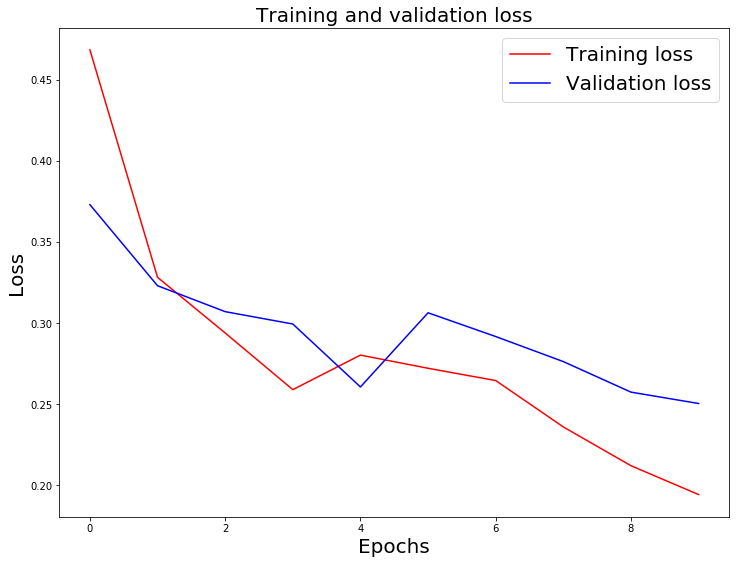

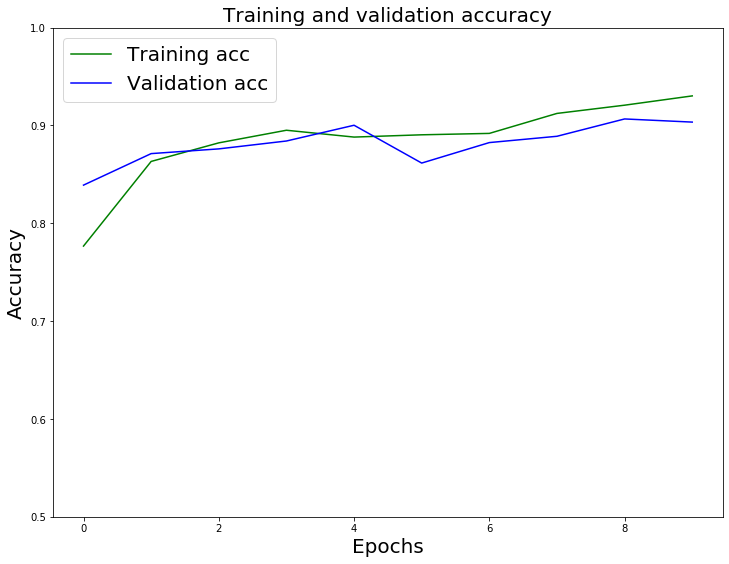

In [98]:
model_plot(model7_text_final)

In [99]:
f1_model7_text = rnn_f1(model7_text, x_test_text_rnn)
print('F1 score of model7_text: ', f1_model7_text)

F1 score of model7_text:  0.9013353676556497


In [ ]:
f1_matrix = np.array[]

# Model 8: Complex RNN Model with Glove Embedding Inputs

In [145]:
model8_text = Sequential(name = 'model8_text')
model8_text.add(Embedding(input_dim = max_vocab, output_dim = 100, input_length=max_text_length, weights=[embedding_matrix], trainable=False))
model8_text.add(Bidirectional(LSTM(64, dropout = 0.2, return_sequences=True)))
model8_text.add(Bidirectional(LSTM(16, return_sequences=False)))
model8_text.add(Dense(32, activation = 'relu'))
model8_text.add(Dropout(rate=0.5))
model8_text.add(Dense(1, activation = 'sigmoid'))
model8_text.summary()

Model: "model8_text"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 817, 100)          7403200   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 817, 128)          84480     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 7,507,329
Trainable params: 104,129
Non-trainable params: 7,403,200
_______________________________________

In [146]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
model8_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model8_text_final = model8_text.fit(x_train_text_rnn, y_train, epochs=10,validation_split=0.1, batch_size=32,callbacks=[early_stop])
model8_text.evaluate(x_test_text_rnn, y_test)

Epoch 1/10
175/175 [==============================] - 105s 601ms/step - loss: 0.4452 - accuracy: 0.7967 - val_loss: 0.2830 - val_accuracy: 0.9002
Epoch 2/10
175/175 [==============================] - 97s 556ms/step - loss: 0.2722 - accuracy: 0.9019 - val_loss: 0.2431 - val_accuracy: 0.9195
Epoch 3/10
175/175 [==============================] - 97s 554ms/step - loss: 0.2057 - accuracy: 0.9327 - val_loss: 0.1548 - val_accuracy: 0.9533
Epoch 4/10
175/175 [==============================] - 98s 561ms/step - loss: 0.1983 - accuracy: 0.9323 - val_loss: 0.2191 - val_accuracy: 0.9211
Epoch 5/10
175/175 [==============================] - 97s 555ms/step - loss: 0.1669 - accuracy: 0.9420 - val_loss: 0.1994 - val_accuracy: 0.9388
Epoch 6/10
175/175 [==============================] - 94s 538ms/step - loss: 0.1502 - accuracy: 0.9509 - val_loss: 0.1537 - val_accuracy: 0.9452
Epoch 7/10
175/175 [==============================] - 94s 535ms/step - loss: 0.1411 - accuracy: 0.9515 - val_loss: 0.1177 - val_a

[0.13071325421333313, 0.9490979313850403]

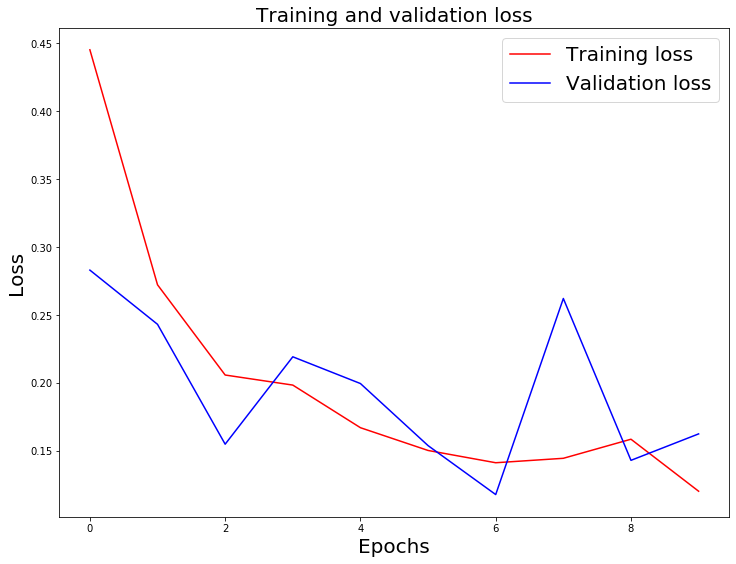

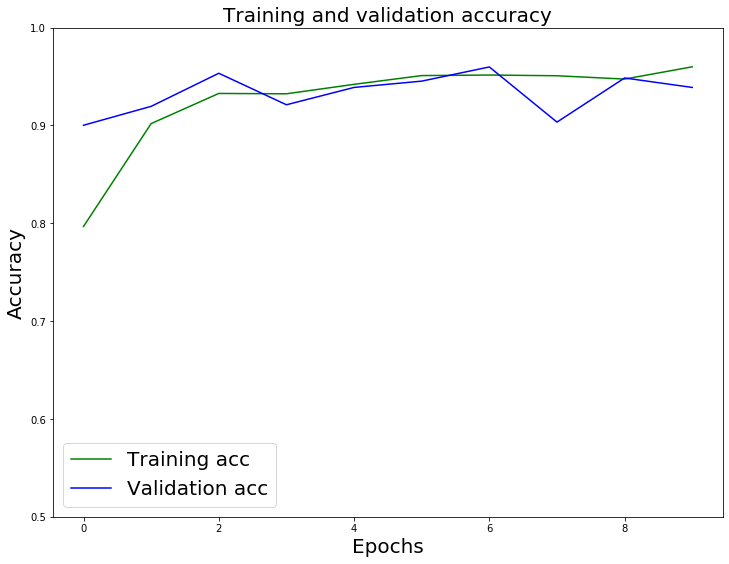

In [147]:
model_plot(model8_text_final)

In [148]:
f1_model8_text = rnn_f1(model8_text, x_test_text_rnn)
print('F1 score of f1_model8_text: ', f1_model8_text)

F1 score of f1_model8_text:  0.9466414833221997


In [107]:
f1_title = (f1_model1_title,f1_model2_title,f1_model3_title,f1_model4_title,f1_model5_title,f1_model7_title,f1_model8_title)

In [129]:
f1_title_mat = pd.DataFrame(columns=('f1_model1_title','f1_model2_title','f1_model3_title','f1_model4_title','f1_model5_title','f1_model7_title','f1_model8_title'))
f1_title_mat = f1_title_mat.append(pd.DataFrame({'f1_model1_title':[f1_model1_title],'f1_model2_title':[f1_model2_title],'f1_model3_title':[f1_model3_title],'f1_model4_title':[f1_model4_title],'f1_model5_title':[f1_model5_title],'f1_model7_title':[f1_model7_title],'f1_model8_title':[f1_model8_title]}))

In [130]:
f1_title_mat

,f1_model1_title,f1_model2_title,f1_model3_title,f1_model4_title,f1_model5_title,f1_model7_title,f1_model8_title
0,0.928129,0.94315,0.940624,0.898503,0.896988,0.917335,0.941503


In [136]:
f1_text_mat = pd.DataFrame(columns=('f1_model1_text','f1_model2_text','f1_model3_text','f1_model4_text','f1_model5_text','f1_model7_text','f1_model8_text'))
f1_text_mat = f1_text_mat.append(pd.DataFrame({'f1_model1_text':[f1_model1_text],'f1_model2_text':[f1_model2_text],'f1_model3_text':[f1_model3_text],'f1_model4_text':[f1_model4_text],'f1_model5_text':[f1_model5_text],'f1_model7_text':[f1_model7_text],'f1_model8_text':[f1_model8_text]}))

In [137]:
f1_text_mat

,f1_model1_text,f1_model2_text,f1_model3_text,f1_model4_text,f1_model5_text,f1_model7_text,f1_model8_text
0,0.65617,0.973806,0.977883,0.92995,0.928384,0.908222,0.973903
